In [1]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
from IPython.display import HTML, clear_output


import brax
import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac
import matplotlib.pyplot as plt
import plotly.express as px
import time
from datetime import datetime

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


# Initial Rollout

In [4]:
from bracketbot_env_balance import Balance_BracketBot

In [5]:
envs.register_environment("Balance_BracketBot", Balance_BracketBot)
env = envs.get_environment("Balance_BracketBot")

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

/Users/magi/Code/robots/.venv/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


In [6]:
ROLLOUT_LENGTH = 1000

In [43]:
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)

# make it roll
rollout = [state.pipeline_state]
metrics_keys = state.metrics.keys()
untrained_metrics = {key : [] for key in metrics_keys}

for i in range(ROLLOUT_LENGTH):
    rng, _ = jax.random.split(rng)
    action = jax.random.uniform(rng, (env.action_size,), minval=-1, maxval=1)
    done = state.done
    state = jit_step(state, action)

    if not done:
        state = jit_step(state, action)
    else:
        state = jit_reset(rng)

    rollout.append(state.pipeline_state)
    for key in metrics_keys:
        untrained_metrics[key].append(state.metrics[key])

    
# html_content = html.render(env.sys, rollout)
# with open('untrained_rollout.html', 'w') as out:
#     out.write(html_content)  
# HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))

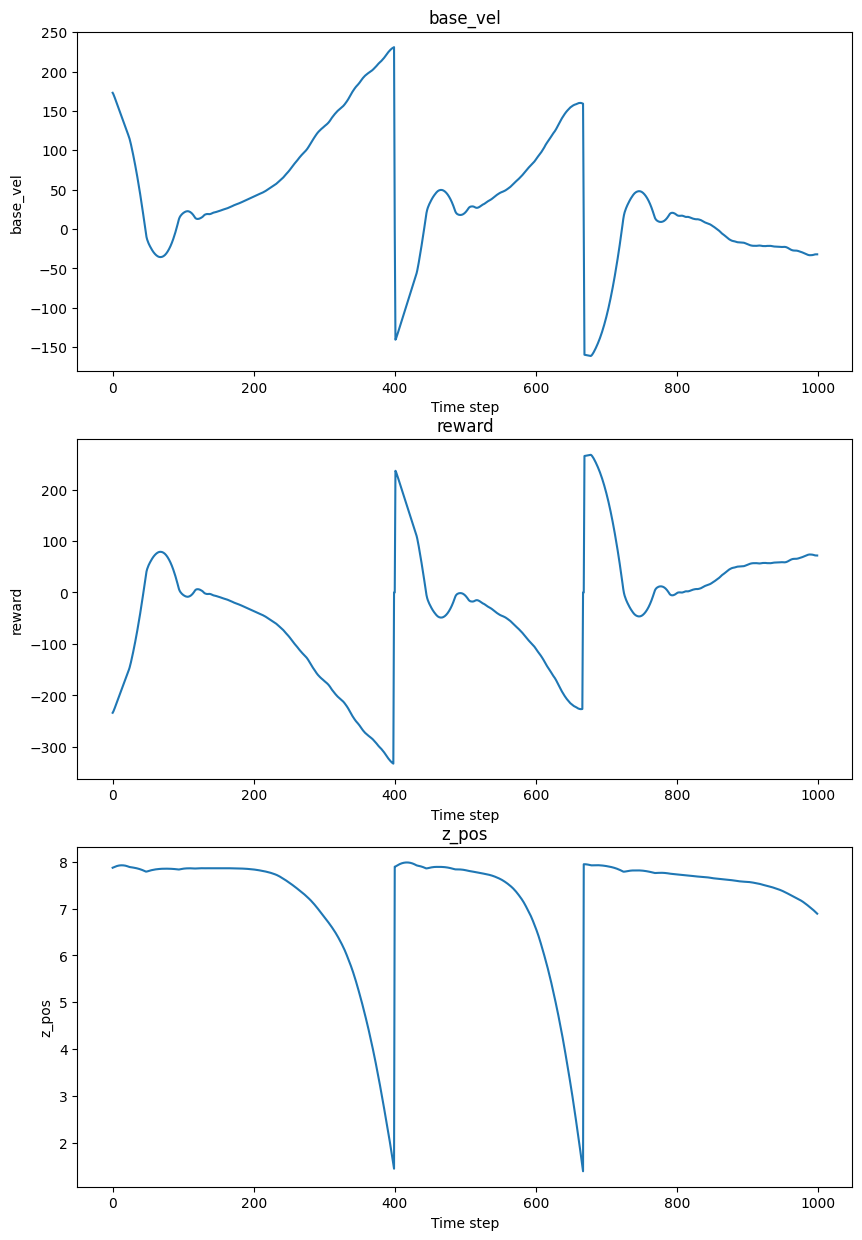

In [44]:
n = len(metrics_keys)
plt.figure(figsize=(10, 5 * n))

i = 1
for k, v in untrained_metrics.items():
    plt.subplot(n, 1, i)
    plt.title(f"{k}")
    plt.xlabel("Time step")
    plt.ylabel(f"{k}")
    plt.plot(v)
    i += 1

In [9]:
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)

In [21]:
# action = jax.random.uniform(rng, (env.action_size,), minval=-2, maxval=2)
# state = jit_step(state, action)

# pipeline_state = state.pipeline_state
# xs = pipeline_state.x.pos[:, 0]
# ys = pipeline_state.x.pos[:, 1]
# zs = pipeline_state.x.pos[:, 2]

# fig = px.scatter_3d(x=xs, y=ys, z=zs)
# fig.show()

In [9]:
train_fn = functools.partial(
    ppo.train,
    num_timesteps=20_000_000, 
    num_evals=20,
    reward_scaling=10, 
    episode_length=1000, 
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10, 
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-2,
    num_envs=4096, # the number of parallel environments running 
    batch_size=2048,
    seed=0
)

### run this version if intending to load an existing policy (to initalize whatever object functools needs)
# train_fn = functools.partial(
#     ppo.train,
#     num_timesteps=10, 
#     num_evals=20,
#     reward_scaling=10, 
#     episode_length=1000, 
#     normalize_observations=True,
#     action_repeat=1,
#     unroll_length=10, 
#     num_minibatches=32,
#     num_updates_per_batch=4,
#     discounting=0.97,
#     learning_rate=3e-4,
#     entropy_cost=1e-2,
#     num_envs=10, # the number of parallel environments running 
#     batch_size=2048,
#     seed=0
# )

In [10]:
# code was borrowed from Brax's `tutorial` collab notebook

# going to add how long the average rollout last...
xdata, ydata = [], []
times = [datetime.now()]

# if using zero reward for terminating state, need to change the metri used during this evaluation
def progress(num_steps, metrics):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics['eval/episode_reward'])
    clear_output(wait=True)
    plt.xlim([0, train_fn.keywords['num_timesteps']])
    plt.xlabel('# environment steps')
    plt.ylabel('reward per episode')
    plt.plot(xdata, ydata)
    plt.show()


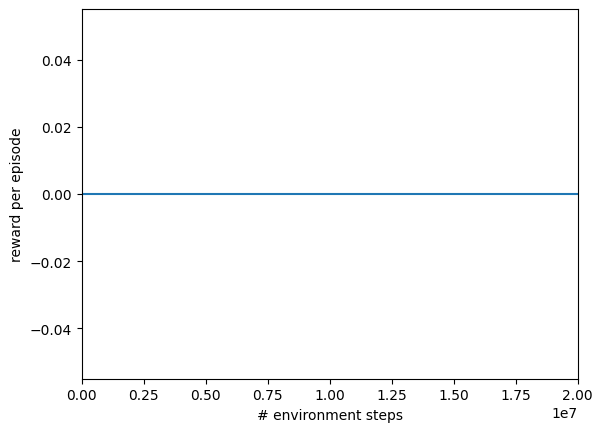

In [11]:
time_start = time.time()
make_inference_fn, params, metrics = train_fn(
    environment=env,
    progress_fn=progress)
time_end = time.time()

In [12]:
print(f"Time to Train: {(time_end - time_start) / 60:2f} mins.")

Time to Train: 46.610687 mins.


In [58]:
# model.save_params("bracket_policy_balance", params)
params = model.load_params("bracket_policy_balance")
inference_fn = make_inference_fn(params) 

In [59]:
rng = jax.random.PRNGKey(0)
jit_inference_fn = jax.jit(inference_fn)
state = jit_reset(rng)

rollout = [state.pipeline_state]
metrics_keys = state.metrics.keys()
trained_metrics = {key : [] for key in metrics_keys}

for i in range(ROLLOUT_LENGTH):
    rng, _ = jax.random.split(rng)
    act_rng, rng = jax.random.split(rng)

    action, _  = inference_fn(state.obs, act_rng)
    done = state.done
    state = jit_step(state, action)

    if not done:
        state = jit_step(state, action)
    else:
        state = jit_reset(rng)

    rollout.append(state.pipeline_state)
    for key in metrics_keys:
        trained_metrics[key].append(state.metrics[key])

    
# html_content = html.render(env.sys, rollout)
# with open('untrained_rollout.html', 'w') as out:
#     out.write(html_content)  
HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))

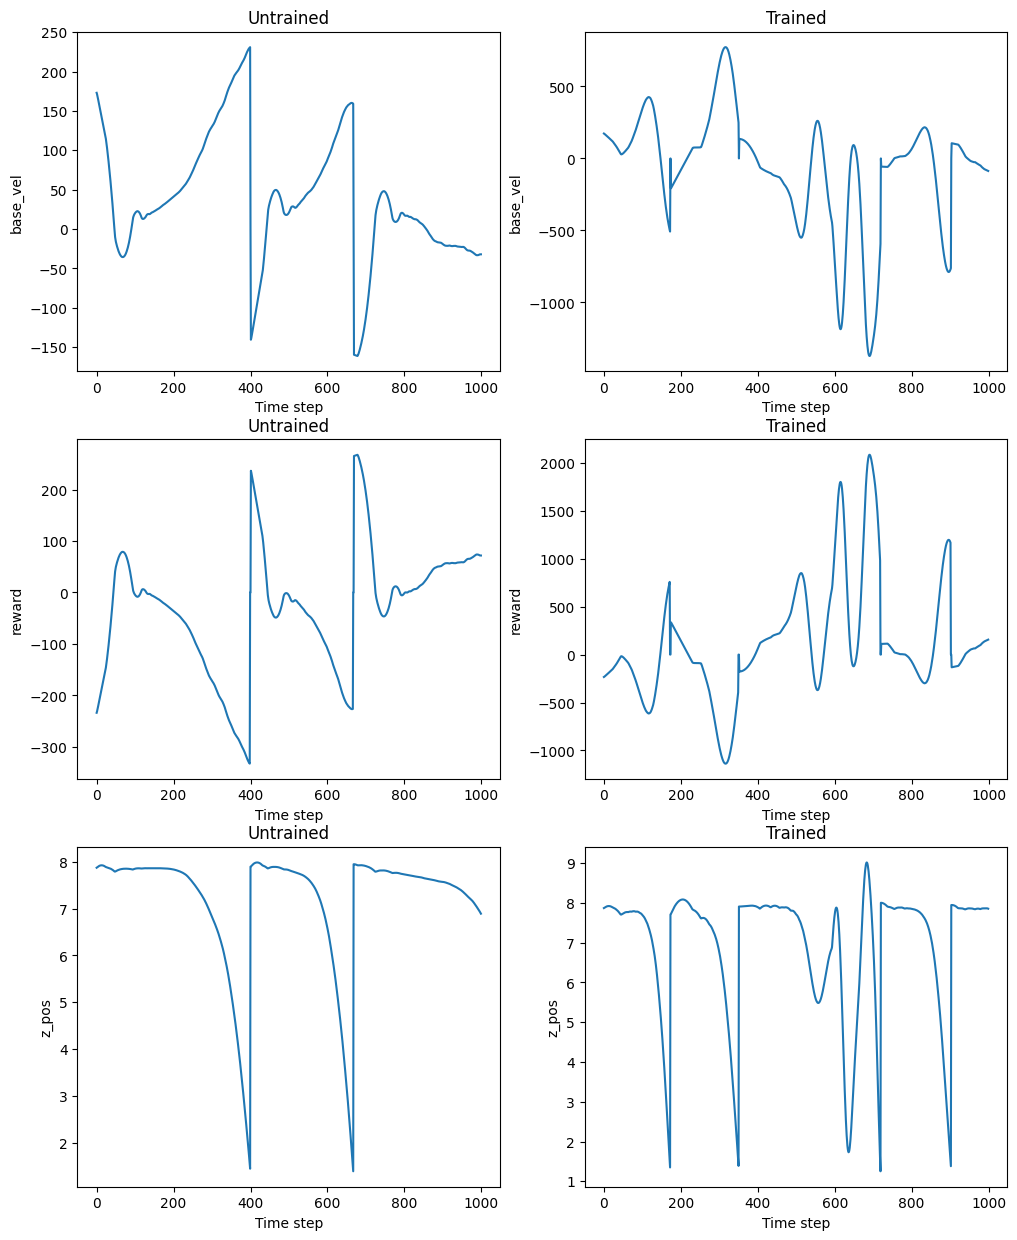

In [60]:
n = len(metrics_keys)
plt.figure(figsize=(12, 5 * n))

i = 1
for key, untrained_v, trained_v in zip(metrics_keys, untrained_metrics.values(), trained_metrics.values()):
    plt.subplot(n, 2, i)
    plt.title(f"Untrained")
    plt.xlabel("Time step")
    plt.ylabel(f"{key}")
    plt.plot(untrained_v)
    i += 1

    plt.subplot(n, 2, i)
    plt.title(f"Trained")
    plt.xlabel("Time step")
    plt.ylabel(f"{key}")
    plt.plot(trained_v)
    i += 1
    


In [ ]:
print(env.action_size)
print(env.observation_size)